In [6]:
import scipy
import jax
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as random
import jax.numpy as jnp

In [7]:
def sample_sphere(J):
    """
    2 dimensional sample
    
    N_samples: Number of samples
    Returns a (N_samples, 2) array of samples
    """
    alphas = jnp.linspace(0, 2*jnp.pi * (1 - 1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs, ys], axis=1)
    return mf


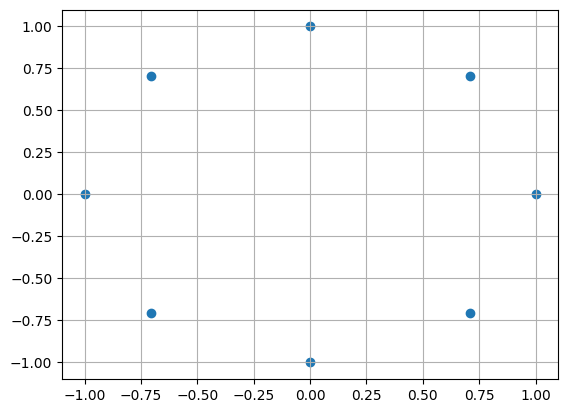

In [12]:
J = 8
mf = sample_sphere(J)
plt.scatter(mf[:, 0], mf[:, 1])
plt.grid('both')

In [13]:
beta_min = 0.001
beta_max = 3

def beta_t(t):
    """
    t: time (number)
    returns beta_t as explained above
    """
    return beta_min + t*(beta_max - beta_min)

def alpha_t(t):
    """
    t: time (number)
    returns alpha_t as explained above
    """
    return t*beta_min + 0.5 * t**2 * (beta_max - beta_min)

def drift(x, t):
    """
    x: location of J particles in N dimensions, shape (J, N)
    t: time (number)
    returns the drift of a time-changed OU-process for each batch member, shape (J, N)
    """
    return -0.5*beta_t(t)*x

def dispersion(t):
    """
    t: time (number)
    returns the dispersion
    """
    return jnp.sqrt(beta_t(t))

def mean_factor(t):
    """
    t: time (number)
    returns m_t as above
    """
    return jnp.exp(-0.5 * alpha_t(t))

def var(t):
    """
    t: time (number)
    returns v_t as above
    """
    return 1 - jnp.exp(-alpha_t(t))


In [14]:
from jax.scipy.special import logsumexp

def log_hat_pt(x, t):
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above
    
    """
    N = mf.shape[0]
    means = mf * mean_factor(t)
    v = var(t)
    potentials = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    # this is equivalent to
    # return jnp.log(1/N * jnp.sum(jnp.exp(potentials)))
    # but is numerically more stable
    return logsumexp(potentials, axis=0, b=1/N)

nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))


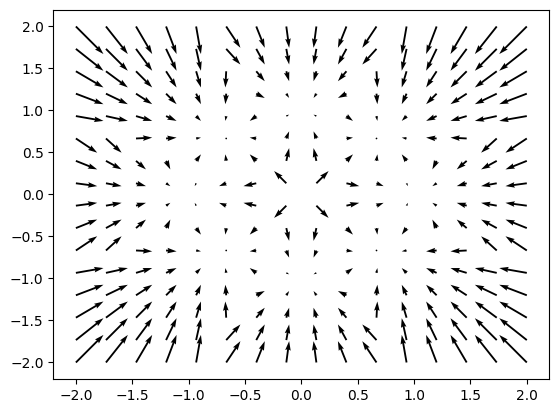

In [16]:
from functools import partial

def plot_score(score, t, area_min=-1, area_max=1):
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.001, -2, 2)